In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

In [5]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import pacf,acf
from statsmodels.tsa.arima.model import ARIMA

In [6]:
%pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 50.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 13.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompa

In [7]:
%pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 18.8 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [8]:
import scikeras

2024-05-09 11:22:43.671926: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 11:22:43.672114: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 11:22:43.861447: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense,Dropout
# from scikeras.wrappers import KerasClassifier

Now creating the input signal u(n)  = 0.5u(n-1) - 0.2u(n-2) + 0.3\theta(n-1) - 0.1\theta(n-2) + \theta(n)
and the output signal would be y(n) = 0.8u(n) - 0.13u(n-2) + 0.2y(n-1) - 0.11y(n-3) - 0.11u^2(n-1) + 0.13y^2(n-2) - 0.18u(n-1)y(n-1)

In [10]:
ar_params = np.array([0.5, -0.2])  # AR coefficients
ma_params = np.array([0.3, -0.1])  # MA coefficients
d = 0  # differencing order
arma_process = ArmaProcess(ar_params, ma_params)
np.random.seed(42) # for maintaining reproducibility i.e. maintaining of the same order of random number each time u run the code.
n_samples = 1000
synthetic_data = arma_process.generate_sample(nsample=n_samples)
# Fit ARIMA model to the synthetic data to ensure stationarity
arima_model = ARIMA(synthetic_data, order=(2, d, 2))
arima_result = arima_model.fit()
# plt.figure(figsize=(10, 6))
# plt.plot(synthetic_data, label='Synthetic Data')
# plt.title('Synthetic Time Series Data and ARMA Fitted Values')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.legend()
# plt.show()
t = range(1000)
df_input = pd.DataFrame({'t':t,'Input':synthetic_data})
fig = px.line(df_input,x = 't',y = 'Input', title  = 'Input variable vs time')
fig.update_layout(xaxis_title = 'Time',yaxis_title = 'Input Value',legend_title = 'Input vs time')
fig.show()
fig.write_image('Input_signal.png')

In [11]:
l = df_input['Input'].to_list()
def function_output(n_datapoints,a,b,c):
    l1 = []
    l1.append(a)
    l1.append(b)
    l1.append(c)
    #y(n) = 0.8u(n) - 0.13u(n-2) + 0.2y(n-1) - 0.11y(n-3) - 0.11u^2(n-1) + 0.13y^2(n-2) - 0.18u(n-1)y(n-1)
    for i in range(3,n_datapoints):
        x = 0.8*l[i] - 0.13*l[i-2] + 0.2*l1[i-1] - 0.11*l1[i-3] - 0.11*pow(l[i-1],2) + 0.13*pow(l1[i-2],2) - 0.18*l[i-1]*l1[i-1]
        l1.append(x)
    return l1
n_datapoints = 1000
n = np.arange(n_datapoints)
o_n = function_output(n_datapoints,0,0.5,0.7)
df_output = pd.DataFrame({'t':n,'Output':o_n})
df_output

,t,Output
0,0,0.000000
1,1,0.500000
2,2,0.700000
3,3,0.867166
4,4,-0.167929
...,...,...
995,995,-0.204026
996,996,0.916054
997,997,0.324689
998,998,-0.221762


In [12]:
t1 = range(1000)
fig1 = px.line(df_output,x = 't',y = 'Output', title  = 'Output variable vs time')
fig1.update_layout(xaxis_title = 'Time',yaxis_title = 'Output Value',legend_title = 'Output vs time')
fig1.show()
fig1.write_image('Output_Signal.png')

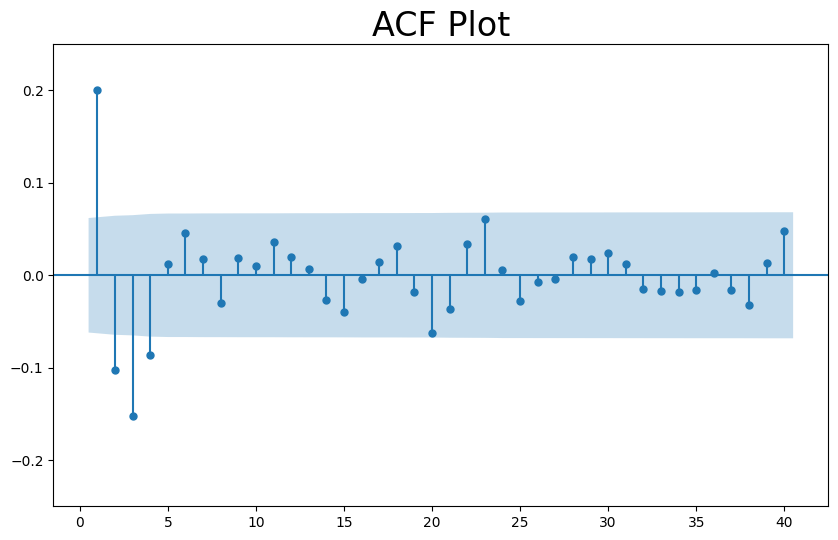

In [13]:
X1 = df_output['Output'].values
lags = 40
acf_fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(X1, lags=lags, zero  = False, ax=ax)
ax.set_title("ACF Plot", size=24)
ax.set_ylim(-0.25, 0.25)
plt.show()

In [14]:
pacf_values, conf_int = acf(X1, nlags = 30, alpha = 0.05)
# now setting the significanc level (e.g. 0.05 for 95% confidence interval) generally we take this only
significant_lags_pacf1 = np.where(np.abs(pacf_values)> 0.05)[0]
significant_lags_pacf = significant_lags_pacf1[1:]
significant_lags_pacf

array([ 1,  2,  3,  4, 20, 23])

In [15]:
#Now let's create the lagged Dataframe
lagged_data = pd.concat([df_output['Output'].shift(lag) for lag in range (1,max(significant_lags_pacf)+1)], axis = 1)
lagged_data.columns = [f'Lag_{lag}' for lag in range (1,max(significant_lags_pacf)+1)]
lagged_data_dropped = lagged_data.dropna()
lagged_data_dropped

,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,...,Lag_14,Lag_15,Lag_16,Lag_17,Lag_18,Lag_19,Lag_20,Lag_21,Lag_22,Lag_23
23,0.046945,0.081836,0.327107,-0.786989,-0.219699,0.240005,-0.301518,-0.791835,-1.356815,-0.839279,...,0.087729,-0.217802,0.379792,0.620264,-0.234664,-0.167929,0.867166,0.700000,0.500000,0.000000
24,-0.693349,0.046945,0.081836,0.327107,-0.786989,-0.219699,0.240005,-0.301518,-0.791835,-1.356815,...,-0.209750,0.087729,-0.217802,0.379792,0.620264,-0.234664,-0.167929,0.867166,0.700000,0.500000
25,-0.644579,-0.693349,0.046945,0.081836,0.327107,-0.786989,-0.219699,0.240005,-0.301518,-0.791835,...,-0.307528,-0.209750,0.087729,-0.217802,0.379792,0.620264,-0.234664,-0.167929,0.867166,0.700000
26,-0.003270,-0.644579,-0.693349,0.046945,0.081836,0.327107,-0.786989,-0.219699,0.240005,-0.301518,...,0.040817,-0.307528,-0.209750,0.087729,-0.217802,0.379792,0.620264,-0.234664,-0.167929,0.867166
27,-0.383738,-0.003270,-0.644579,-0.693349,0.046945,0.081836,0.327107,-0.786989,-0.219699,0.240005,...,-0.839279,0.040817,-0.307528,-0.209750,0.087729,-0.217802,0.379792,0.620264,-0.234664,-0.167929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.406135,-0.273288,-0.752292,-0.960894,0.041173,-0.086483,-0.071735,0.524872,0.497506,-0.509035,...,0.412911,0.872041,0.046033,-1.391870,-1.108868,-0.775063,-1.003707,-0.306217,-0.172424,0.389712
996,-0.204026,-0.406135,-0.273288,-0.752292,-0.960894,0.041173,-0.086483,-0.071735,0.524872,0.497506,...,-0.354960,0.412911,0.872041,0.046033,-1.391870,-1.108868,-0.775063,-1.003707,-0.306217,-0.172424
997,0.916054,-0.204026,-0.406135,-0.273288,-0.752292,-0.960894,0.041173,-0.086483,-0.071735,0.524872,...,-0.295323,-0.354960,0.412911,0.872041,0.046033,-1.391870,-1.108868,-0.775063,-1.003707,-0.306217
998,0.324689,0.916054,-0.204026,-0.406135,-0.273288,-0.752292,-0.960894,0.041173,-0.086483,-0.071735,...,-0.031714,-0.295323,-0.354960,0.412911,0.872041,0.046033,-1.391870,-1.108868,-0.775063,-1.003707


In [16]:
df_output1 = lagged_data_dropped[[f'Lag_{lag}' for lag in significant_lags_pacf]]
df_output1

,Lag_1,Lag_2,Lag_3,Lag_4,Lag_20,Lag_23
23,0.046945,0.081836,0.327107,-0.786989,0.867166,0.000000
24,-0.693349,0.046945,0.081836,0.327107,-0.167929,0.500000
25,-0.644579,-0.693349,0.046945,0.081836,-0.234664,0.700000
26,-0.003270,-0.644579,-0.693349,0.046945,0.620264,0.867166
27,-0.383738,-0.003270,-0.644579,-0.693349,0.379792,-0.167929
...,...,...,...,...,...,...
995,-0.406135,-0.273288,-0.752292,-0.960894,-1.003707,0.389712
996,-0.204026,-0.406135,-0.273288,-0.752292,-0.775063,-0.172424
997,0.916054,-0.204026,-0.406135,-0.273288,-1.108868,-0.306217
998,0.324689,0.916054,-0.204026,-0.406135,-1.391870,-1.003707


In [17]:
X = df_output1
y = df_output['Output'].iloc[20:,]
T = X.shape[1]

# Implementing RNN

In [18]:
X = X.to_numpy()
X = X.reshape(X.shape[0],X.shape[1],1)
a = math.trunc(len(X)*0.6)
b = math.trunc(len(X)*0.2)
c = math.trunc(len(X)*0.2)
X_train = X[0:a]
y_train = y[0:a]
X_val = X[a:a+b]
y_val = y[a:a+b]
X_test = X[a+b:a+b+c]
y_test = y[a+b:a+b+c]

In [19]:
Horizon = 1 # the number of variables u want to predict.
model  = Sequential()
model.add(SimpleRNN(100,return_sequences= True,input_shape = (T,1)))
model.add(SimpleRNN(100))
model.add(Dense(Horizon))
model.compile(optimizer = 'RMSprop', loss = 'mse')
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 6, 100)         │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,401 (118.75 KB)

 Trainable params: 30,401 (118.75 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.fit(X_train,y_train, validation_data = (X_val,y_val),epochs = 100)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.2941 - val_loss: 0.0394
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0373 - val_loss: 0.0071
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0154 - val_loss: 0.0092
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0143 - val_loss: 0.0015
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0119 - val_loss: 0.0092
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0162 - val_loss: 0.0098
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0150 - val_loss: 0.0494
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0143 - val_loss: 0.0287
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0151 - val_loss: 0.0274
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0080 - val_loss: 0.0124
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0105 - val_loss: 0.0074
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.

In [21]:
y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)
y_val_predicted = model.predict(X_val)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


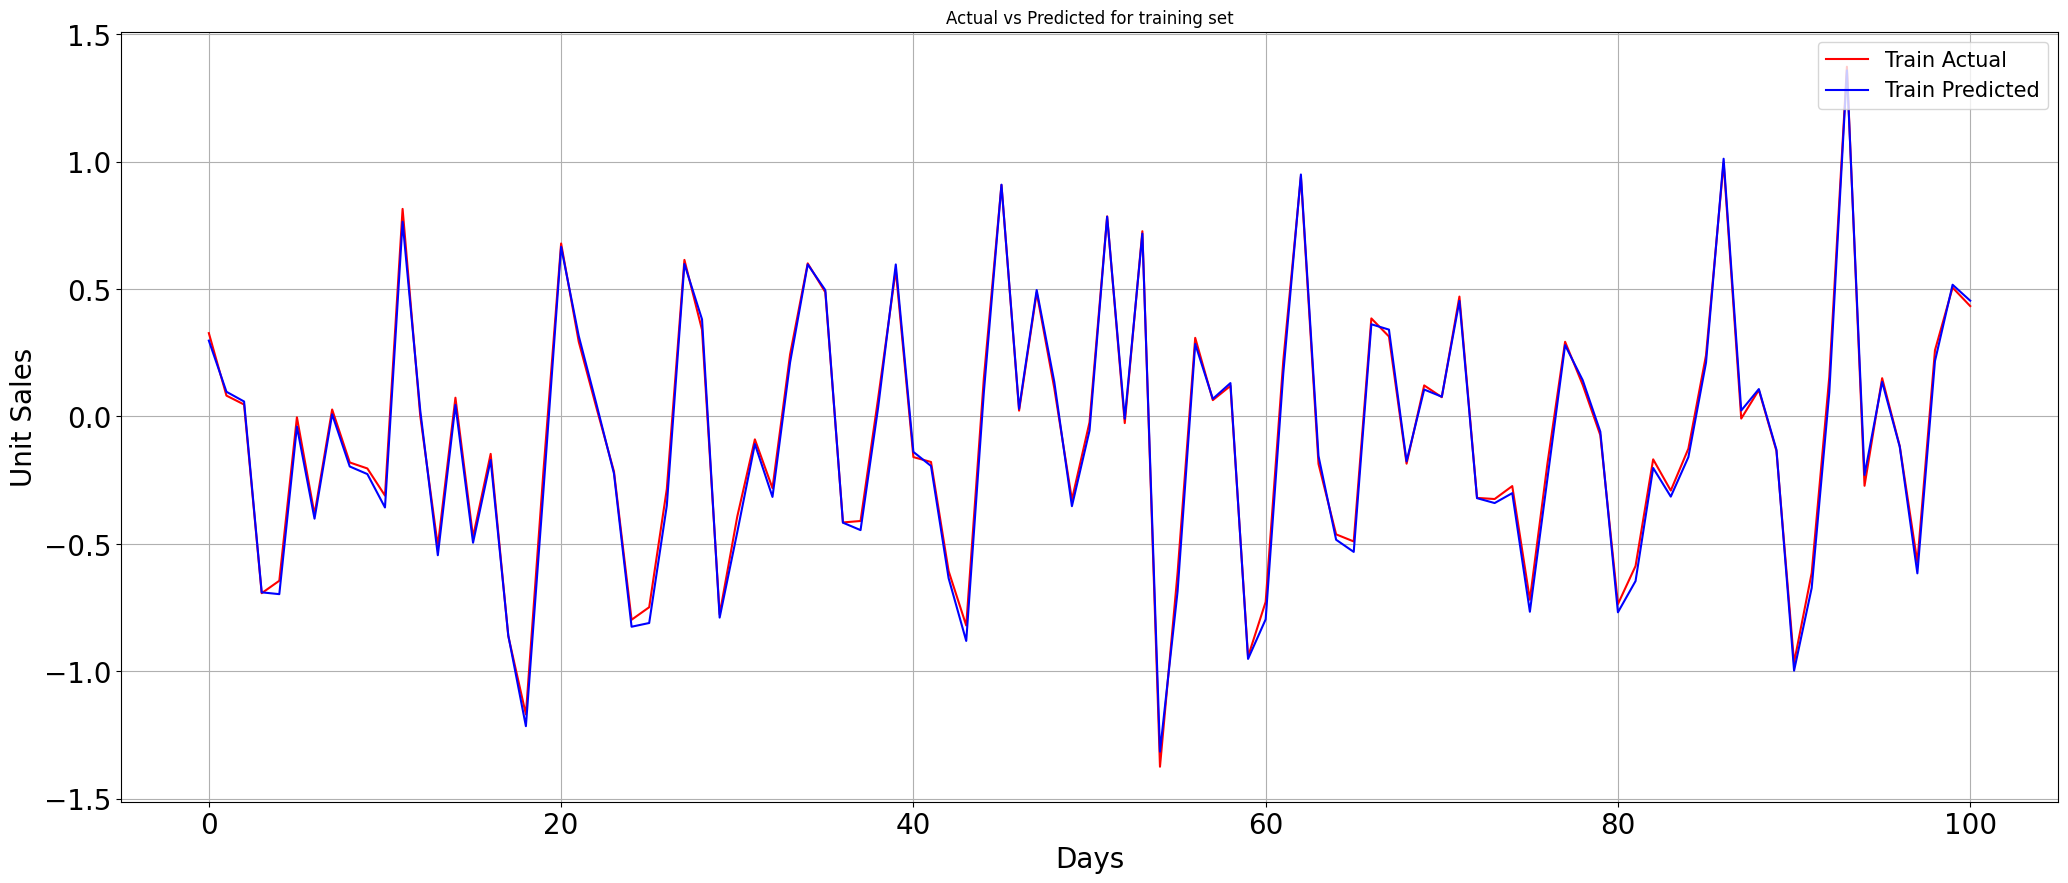

In [22]:
len_train = range(len(X_train))
fig1 = plt.subplots(figsize = (25,10))
plt.plot(len_train[:101],y_train[:101], label = 'Train Actual',color = 'red')
plt.plot(len_train[:101],y_train_predicted[:101], label = 'Train Predicted',color = 'blue')
plt.xlabel('Days',fontsize = 20)
plt.ylabel('Unit Sales',fontsize = 20)
plt.grid(True)
plt.legend(loc = 'upper right',fontsize = '15')
plt.xticks(fontsize = '20')
plt.yticks(fontsize = '20')
plt.title('Actual vs Predicted for training set')
plt.show()

In [23]:
print("MAE: ",mean_absolute_error(y_train,y_train_predicted))
print("MSE: ",mean_squared_error(y_train,y_train_predicted))
print("RMSE: ",math.sqrt(mean_squared_error(y_train,y_train_predicted)))

MAE:  0.025363453242872314
MSE:  0.0010320018213236413
RMSE:  0.03212478515606978


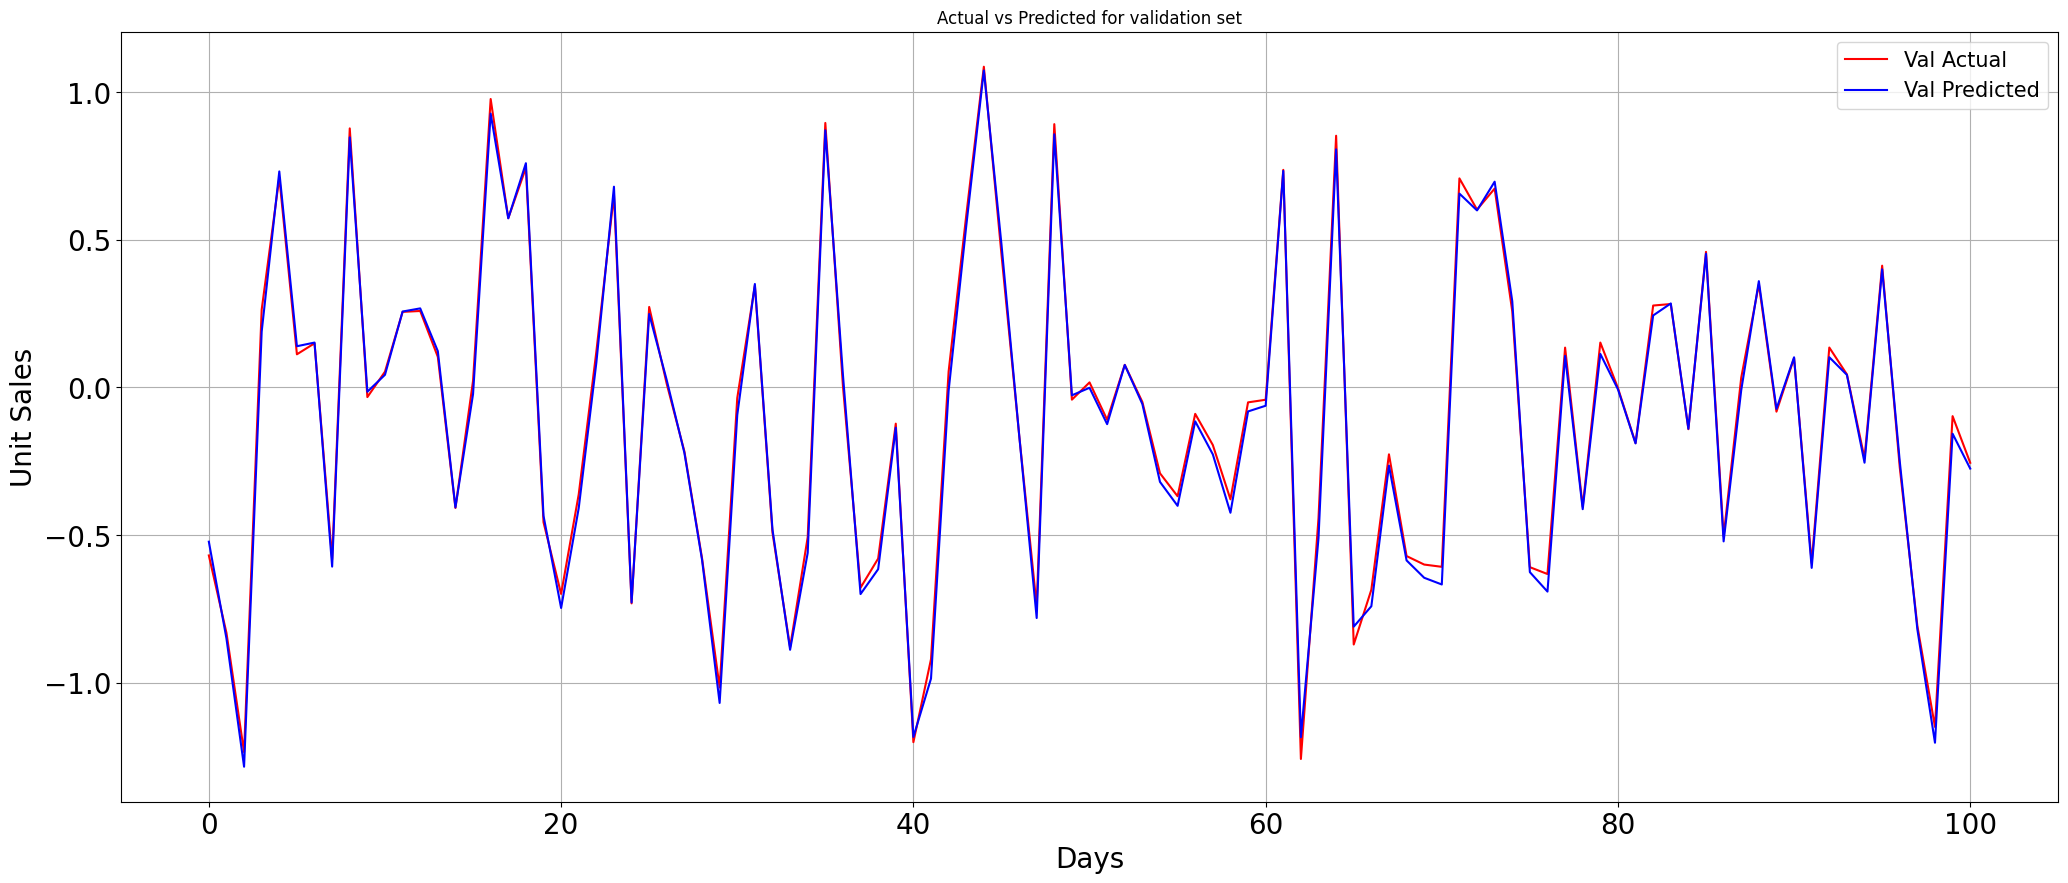

In [24]:
len_val = range(len(X_val))
fig2 = plt.subplots(figsize = (25,10))
plt.plot(len_val[:101],y_val[:101], label = 'Val Actual',color = 'red')
plt.plot(len_val[:101],y_val_predicted[:101], label = 'Val Predicted',color = 'blue')
plt.xlabel('Days',fontsize = 20)
plt.ylabel('Unit Sales',fontsize = 20)
plt.grid(True)
plt.legend(loc = 'upper right',fontsize = 15)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Actual vs Predicted for validation set')
plt.show()

In [25]:
print("MAE: ",mean_absolute_error(y_val,y_val_predicted))
print("MSE: ",mean_squared_error(y_val,y_val_predicted))
print("RMSE: ",math.sqrt(mean_squared_error(y_val,y_val_predicted)))

MAE:  0.024607561649241484
MSE:  0.000964853231067844
RMSE:  0.03106208671464047


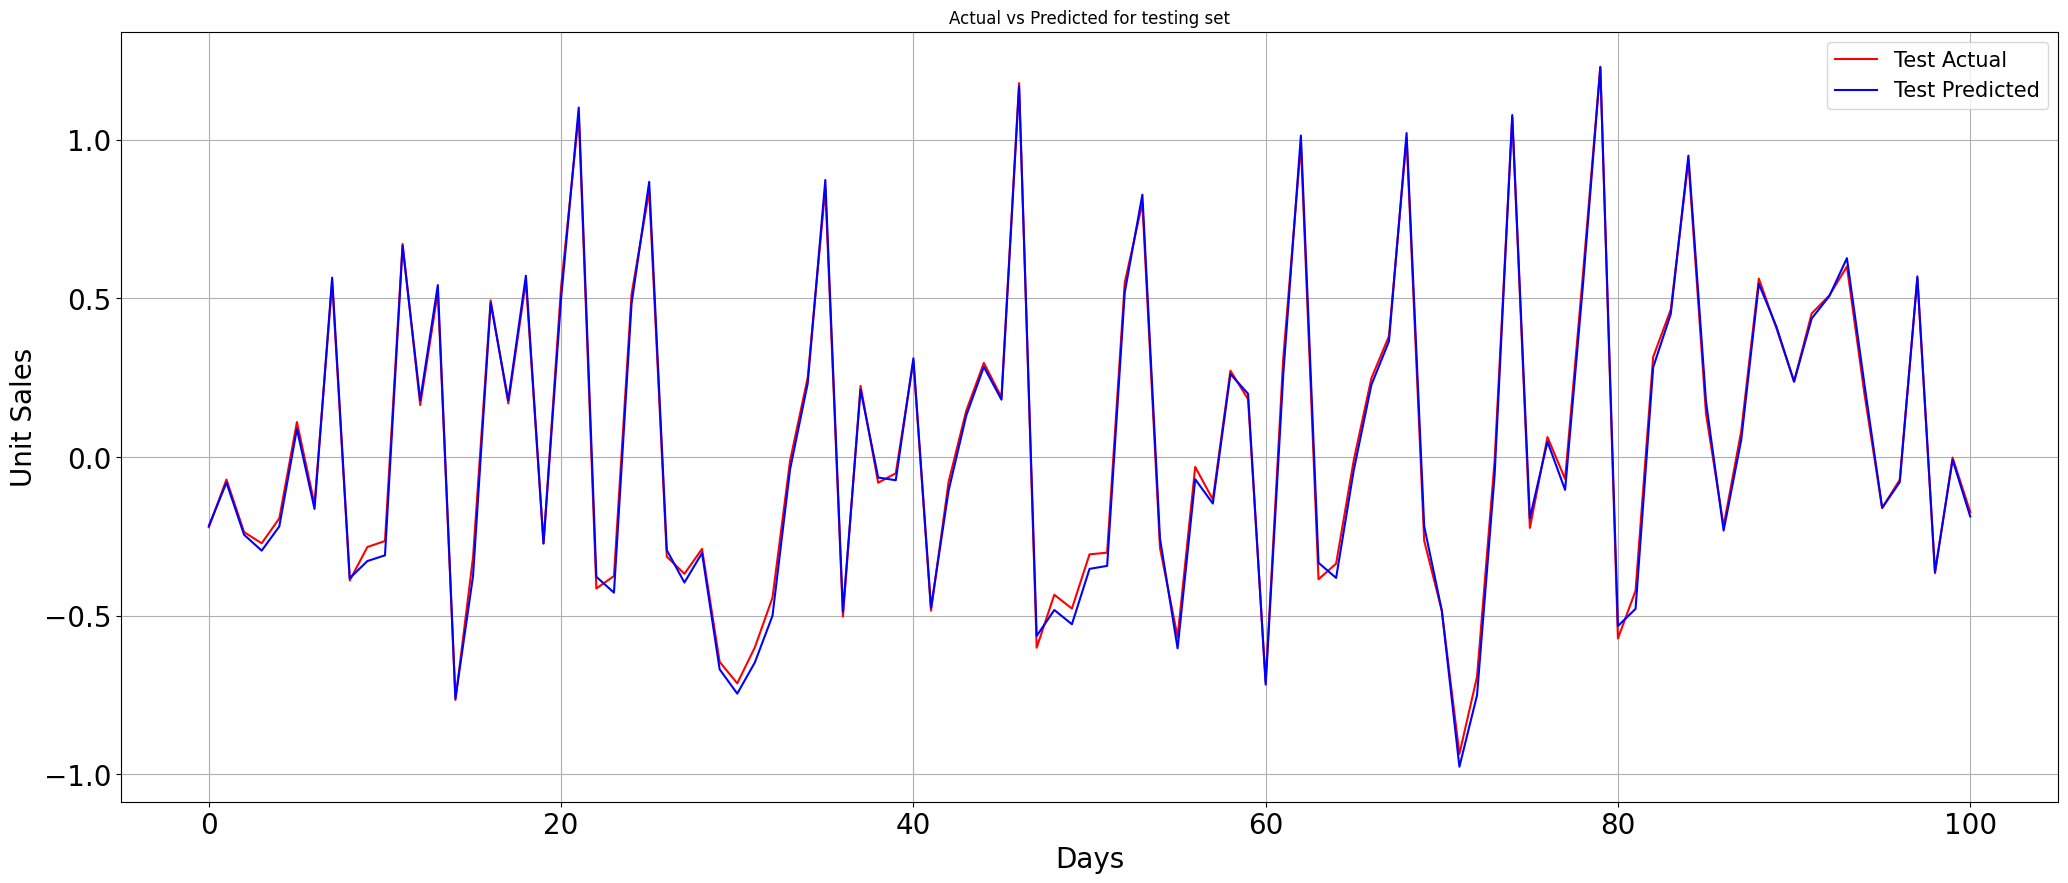

<Figure size 640x480 with 0 Axes>

In [26]:
len_test = range(len(X_test))
fig2 = plt.subplots(figsize = (25,10))
plt.plot(len_test[:101],y_test[:101], label = 'Test Actual',color = 'red')
plt.plot(len_test[:101],y_test_predicted[:101], label = 'Test Predicted',color = 'blue')
plt.xlabel('Days',fontsize = 20)
plt.ylabel('Unit Sales',fontsize = 20)
plt.grid(True)
plt.legend(loc = 'upper right',fontsize = '15')
plt.xticks(fontsize = '20')
plt.yticks(fontsize = '20')
plt.title('Actual vs Predicted for testing set')
plt.show()
plt.savefig('NARMA_RNN_testing.png')

In [27]:
print("MAE: ",mean_absolute_error(y_test,y_test_predicted))
print("MSE: ",mean_squared_error(y_test,y_test_predicted))
print("RMSE: ",math.sqrt(mean_squared_error(y_test,y_test_predicted)))

MAE:  0.022985619880707703
MSE:  0.0008212768319083609
RMSE:  0.028657927906747916


# LSTM Univariate

In [28]:
model1 = Sequential()
model1.add(LSTM(100, input_shape = (T,1),return_sequences = True))# 1 is set because we want to predict one variable only
model1.add(LSTM(100))
model1.add(Dense(Horizon))
model1.compile(optimizer = 'RMSprop',loss = 'mse')
model1.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 6, 100)         │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model1.fit(X_train,y_train,validation_data = (X_val,y_val),epochs = 100)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.2057 - val_loss: 0.1942
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1909 - val_loss: 0.1830
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1825 - val_loss: 0.1730
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1605 - val_loss: 0.1654
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1444 - val_loss: 0.1522
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1442 - val_loss: 0.1362
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1257 - val_loss: 0.1250
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1129 - val_loss: 0.1082
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1002 - val_loss: 0.1114
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1055 - val_loss: 0.1028
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0820 - val_loss: 0.1086
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

In [30]:
y_train_predicted1 = model1.predict(X_train)
y_test_predicted1 = model1.predict(X_test)
y_val_predicted1 = model1.predict(X_val)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


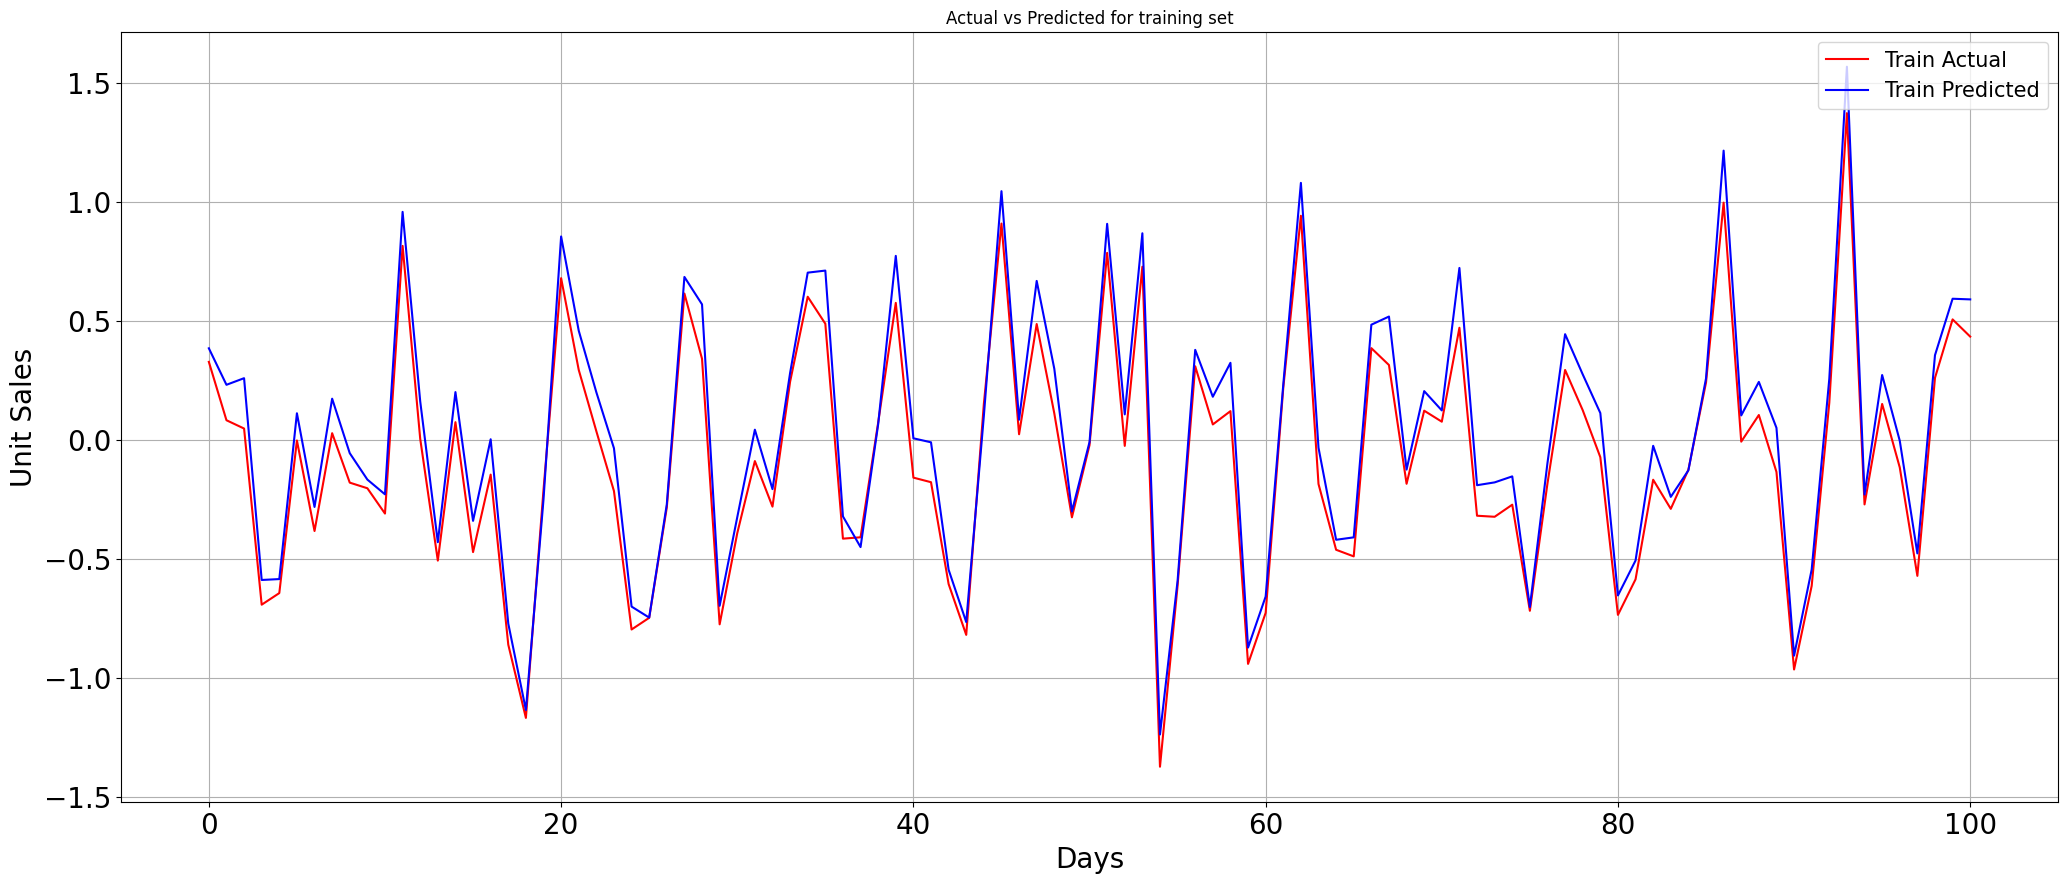

In [31]:
len_train = range(len(X_train))
fig1 = plt.subplots(figsize = (25,10))
plt.plot(len_train[:101],y_train[:101], label = 'Train Actual',color = 'red')
plt.plot(len_train[:101],y_train_predicted1[:101], label = 'Train Predicted',color = 'blue')
plt.xlabel('Days',fontsize = 20)
plt.ylabel('Unit Sales',fontsize = 20)
plt.grid(True)
plt.legend(loc = 'upper right',fontsize = '15')
plt.xticks(fontsize = '20')
plt.yticks(fontsize = '20')
plt.title('Actual vs Predicted for training set')
plt.show()

In [32]:
print("MAE: ",mean_absolute_error(y_train,y_train_predicted1))
print("MSE: ",mean_squared_error(y_train,y_train_predicted1))
print("RMSE: ",math.sqrt(mean_squared_error(y_train,y_train_predicted1)))

MAE:  0.10511230072607783
MSE:  0.014502224871549613
RMSE:  0.12042518370984373


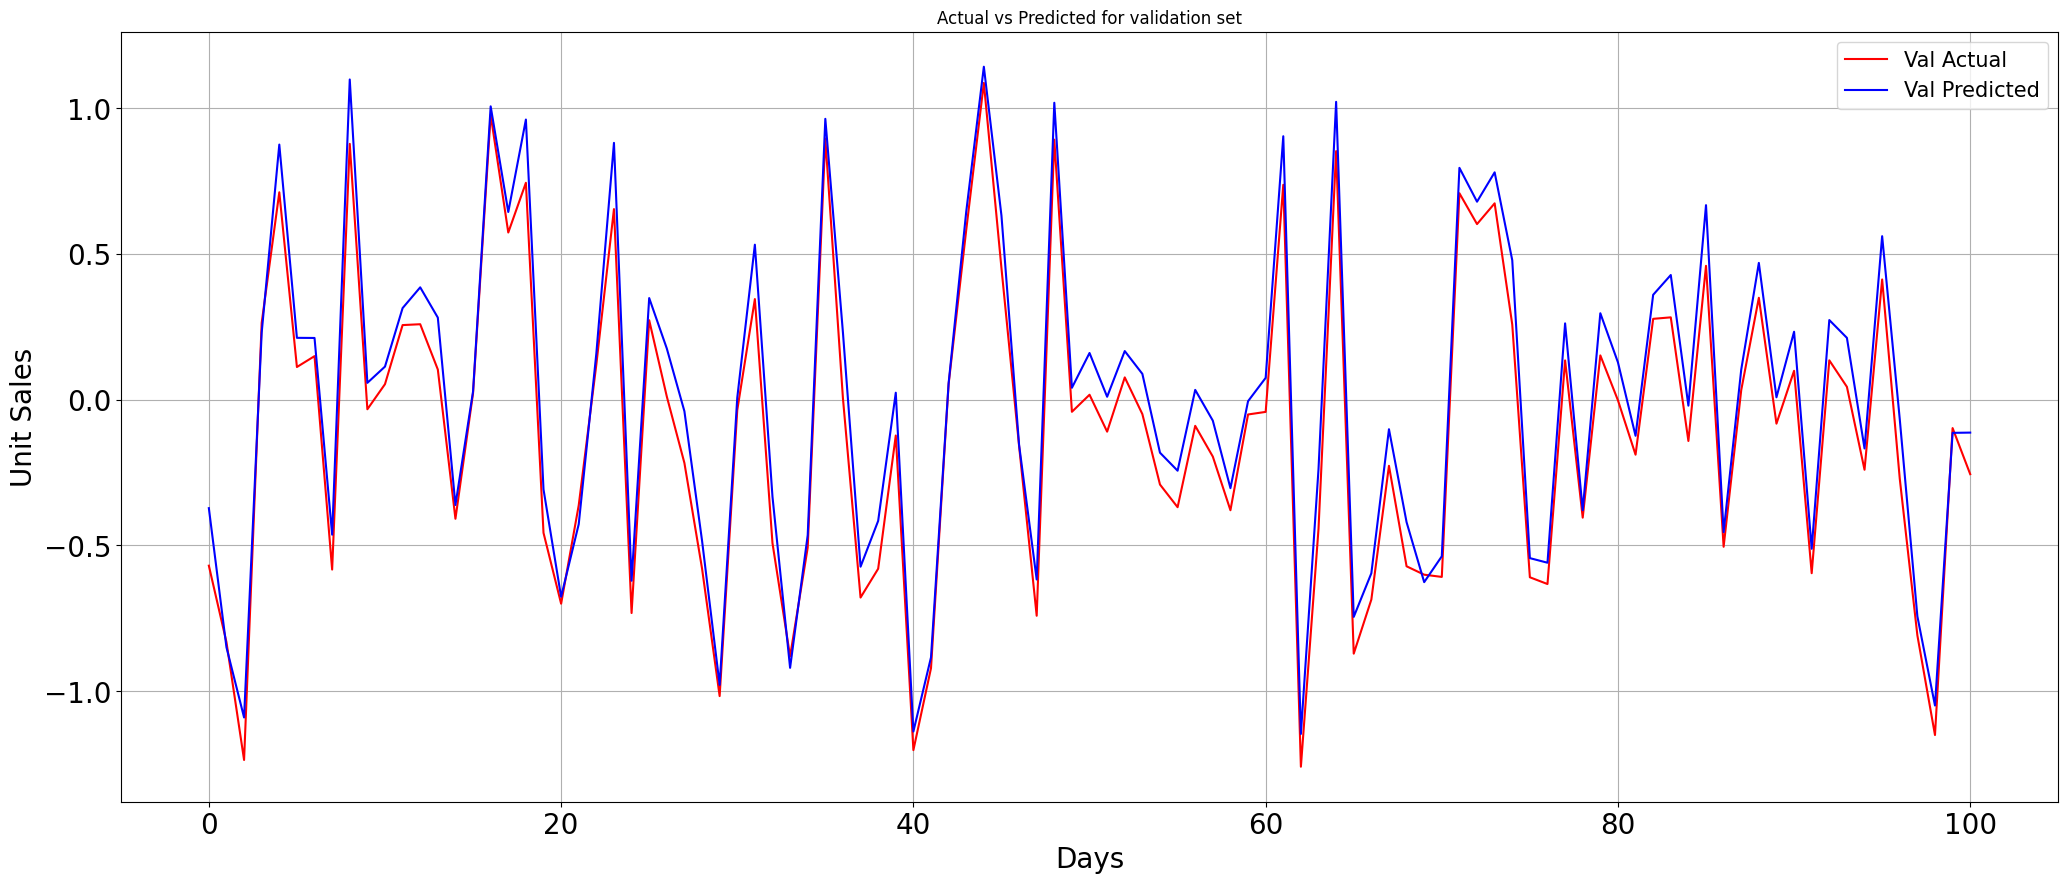

In [33]:
len_val = range(len(X_val))
fig2 = plt.subplots(figsize = (25,10))
plt.plot(len_val[:101],y_val[:101], label = 'Val Actual',color = 'red')
plt.plot(len_val[:101],y_val_predicted1[:101], label = 'Val Predicted',color = 'blue')
plt.xlabel('Days',fontsize = 20)
plt.ylabel('Unit Sales',fontsize = 20)
plt.grid(True)
plt.legend(loc = 'upper right',fontsize = 15)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Actual vs Predicted for validation set')
plt.show()

In [34]:
print("MAE: ",mean_absolute_error(y_val,y_val_predicted1))
print("MSE: ",mean_squared_error(y_val,y_val_predicted1))
print("RMSE: ",math.sqrt(mean_squared_error(y_val,y_val_predicted1)))

MAE:  0.10553691066774945
MSE:  0.014359312215683043
RMSE:  0.11983034764066673


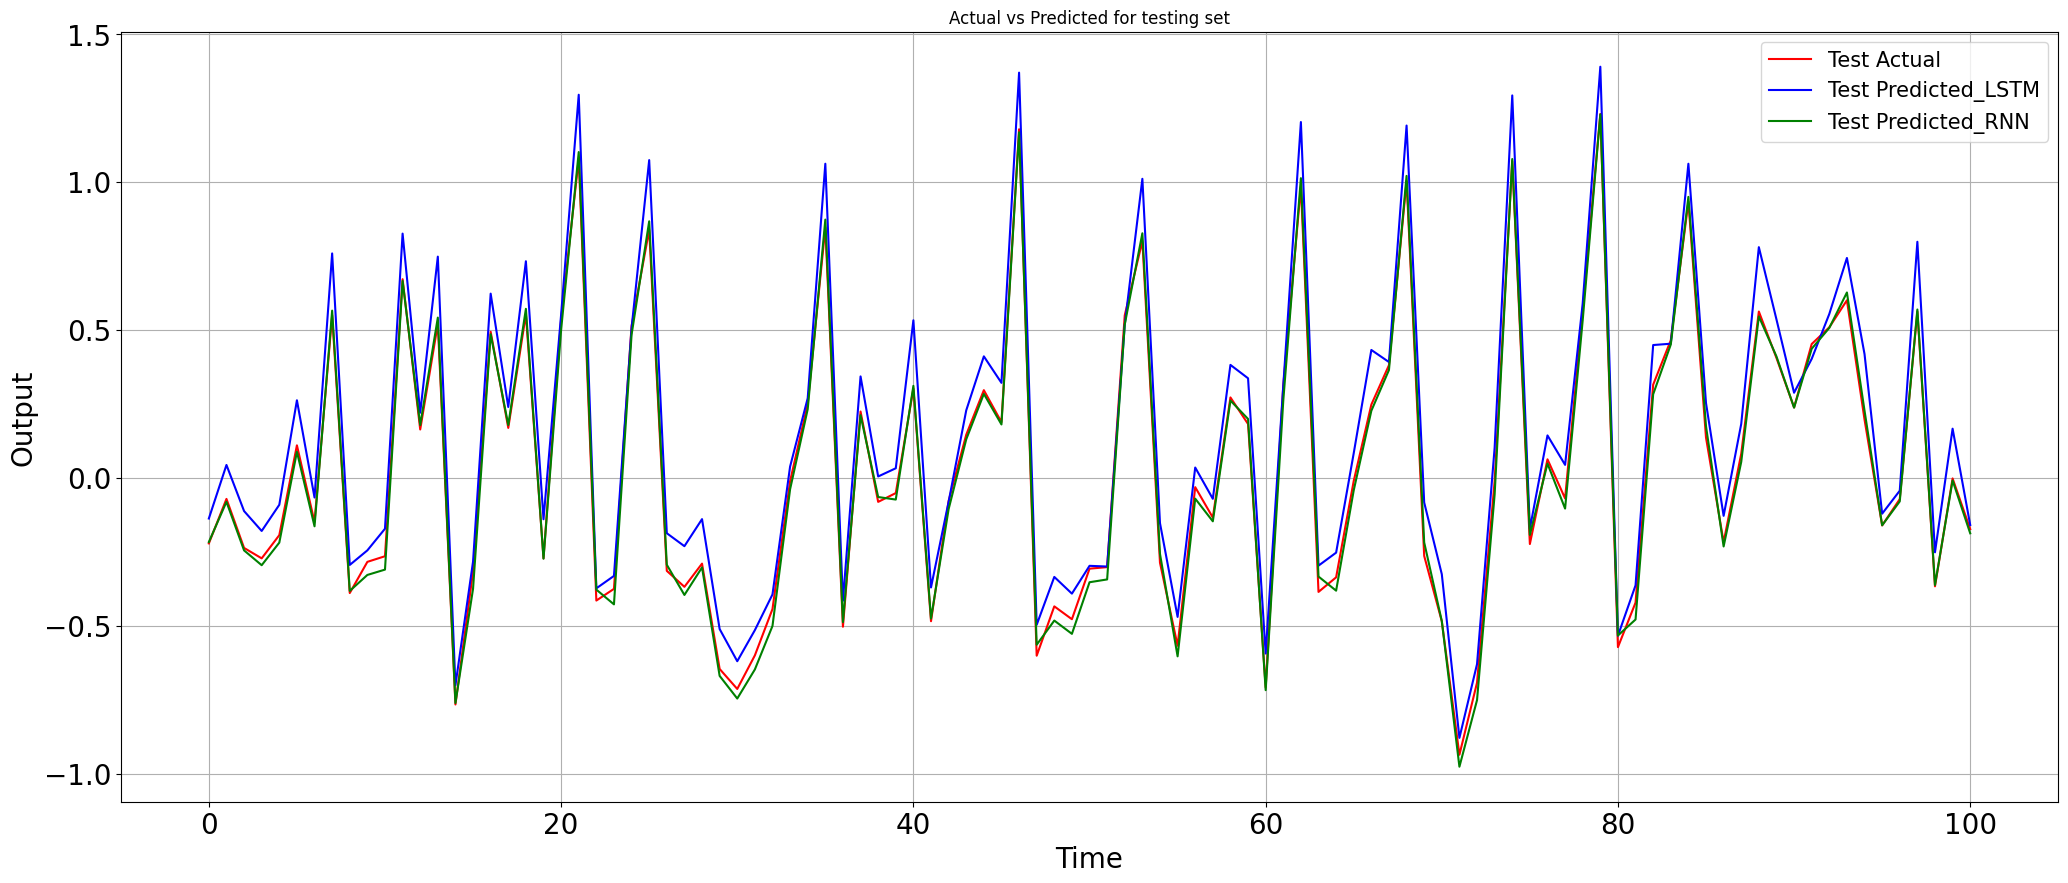

<Figure size 640x480 with 0 Axes>

In [35]:
len_test = range(len(X_test))
fig2 = plt.subplots(figsize = (25,10))
plt.plot(len_test[:101],y_test[:101], label = 'Test Actual',color = 'red')
plt.plot(len_test[:101],y_test_predicted1[:101], label = 'Test Predicted_LSTM',color = 'blue')
plt.plot(len_test[:101],y_test_predicted[:101], label = 'Test Predicted_RNN',color = 'green')
plt.xlabel('Time',fontsize = 20)
plt.ylabel('Output',fontsize = 20)
plt.grid(True)
plt.legend(loc = 'upper right',fontsize = '15')
plt.xticks(fontsize = '20')
plt.yticks(fontsize = '20')
plt.title('Actual vs Predicted for testing set')
plt.show()
plt.savefig('NARMA_LSTM_testing.png')

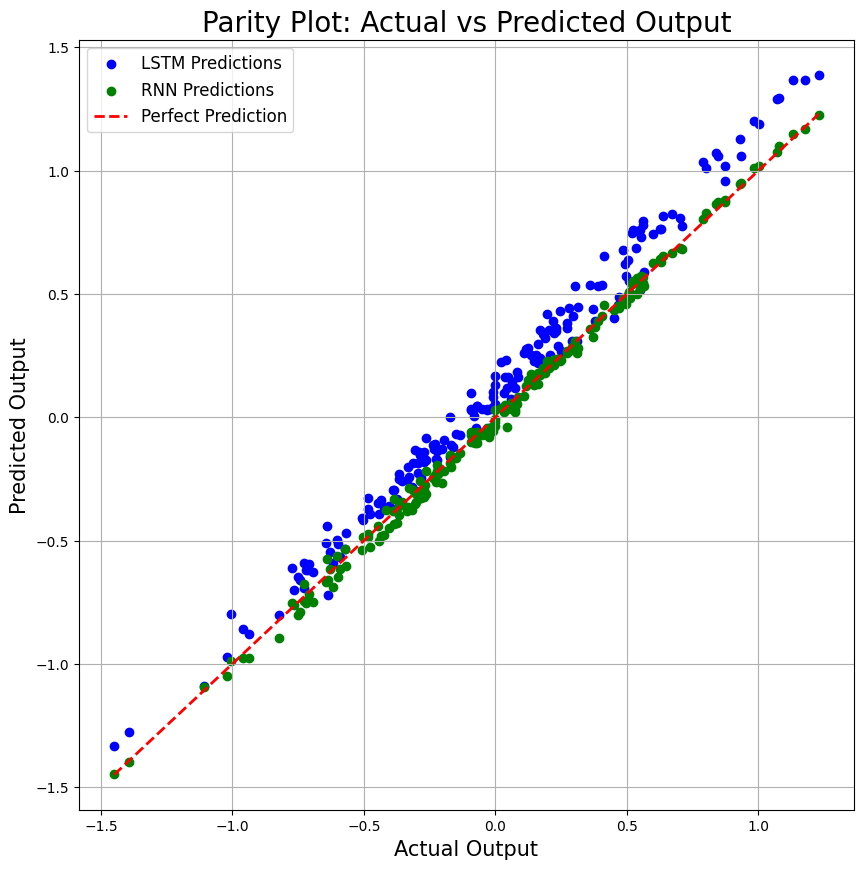

In [37]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_test_predicted1, color='blue', label='LSTM Predictions')
plt.scatter(y_test, y_test_predicted, color='green', label='RNN Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Output', fontsize=15)
plt.ylabel('Predicted Output', fontsize=15)
plt.title('Parity Plot: Actual vs Predicted Output', fontsize=20)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [36]:
print("MAE: ",mean_absolute_error(y_test,y_test_predicted1))
print("MSE: ",mean_squared_error(y_test,y_test_predicted1))
print("RMSE: ",math.sqrt(mean_squared_error(y_test,y_test_predicted1)))

MAE:  0.1064288883585489
MSE:  0.015157695280831206
RMSE:  0.12311659222392084
